# CaringBridge Cancer Journey Framework Responsibility v. Time Data Visualization

Parses the CaringBridge annotation database and constructs multiple visualizations of how cancer patient responsibilities interact with each other and with the progression of time. Using vertical histograms, the density of annotation occurrence is displayed against  scale of the annotated journal's creation date since the parent site's first journal creation date. The histograms are then separated into subplots based on criteria provided by Jacobs Et Al. in the article "A Cancer Journey Framework: Guiding the Design of Holistic Health Technology" and the phases of the cancer journey distinguished within.

In [1]:
# Take care of imports and aliases
# Keep deprecated for broken_violins.ipynb
import pandas as panda
import matplotlib as lib
import matplotlib.pyplot as mpl
import matplotlib.cm as colormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import numpy as np
import random
from tqdm import tqdm
import os

# SQL Compatible Functions that Zach Wrote
from responsibility import get_responsibility_annotations
from data_tools import get_first_journal_ts_from, get_weeks_since_first_from, get_site_id

### Data Collection and Formatting

In [2]:
# Parse responsibility annotation data
responsibility_data = get_responsibility_annotations()
df = panda.DataFrame(responsibility_data)
df.head()

,conflict_status,journal_oid,responsibilities,site_id
0,SINGLE USER,51be14196ca004193500934e,[],106710
1,SINGLE USER,51be14196ca0041935009526,[],106710
2,SINGLE USER,51be14196ca0041935009660,"[sharing_medical_info, compliance]",106710
3,SINGLE USER,51be14196ca00419350098b4,[coordinating_support],106710
4,SINGLE USER,51be14196ca00419350099e0,"[sharing_medical_info, compliance]",106710


In [3]:
# Apply the timestamp functions to all existing data and add the new endpoints onto the dataframe.
results = []
for journal_oid in tqdm(df['journal_oid']):
    results.append(get_weeks_since_first_from(get_site_id(df, journal_oid), journal_oid))
df['time_since_creation'] = results 

100%|██████████| 1909/1909 [00:44<00:00, 43.20it/s]


In [4]:
# Convert the responsibilities and time_since_creation rows into a histogram matrix of these variables.
responsibility_names = ["communicating", "info_filtering", "sharing_medical_info", "clinical_decisions", "preparation", 
                        "symptom_management", "compliance", "coordinating_support", "managing_transitions", 
                        "financial_management", "continued_monitoring", "giving_back", "behavior_changes"]
num_weeks = 30
num_responsibilities = len(responsibility_names)
responsibility_counts = np.zeros((num_responsibilities, num_weeks))
weeksums = np.zeros(num_weeks)

# We don't need any data besides responsibilities and time endpoints, so we narrow it odwn.
this = df[["responsibilities", "time_since_creation"]]

In [5]:
# Run through the desired columns in the dataframe.
for index, row in this.iterrows():
    time_in_weeks = int(row["time_since_creation"])
    if time_in_weeks < num_weeks:
        # Calculate our sums series for proportional transformation
        weeksums[time_in_weeks] += 1
        for responsibility in row['responsibilities']:
            responsibility_index = responsibility_names.index(responsibility)
            responsibility_counts[responsibility_index, time_in_weeks] += 1

In [6]:
# Put the processed data into a dataframe
table_o = panda.DataFrame(responsibility_counts, index=responsibility_names)
table_o.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
communicating,16.0,4.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
info_filtering,52.0,22.0,22.0,16.0,11.0,16.0,13.0,11.0,8.0,2.0,...,3.0,4.0,0.0,2.0,4.0,0.0,2.0,1.0,1.0,4.0
sharing_medical_info,191.0,106.0,112.0,87.0,84.0,75.0,75.0,57.0,45.0,44.0,...,22.0,25.0,19.0,23.0,25.0,17.0,19.0,14.0,12.0,13.0
clinical_decisions,21.0,9.0,8.0,4.0,7.0,2.0,5.0,2.0,2.0,0.0,...,2.0,4.0,3.0,1.0,1.0,0.0,1.0,1.0,4.0,3.0
preparation,79.0,42.0,48.0,30.0,21.0,33.0,18.0,24.0,16.0,11.0,...,6.0,3.0,5.0,7.0,5.0,2.0,2.0,1.0,3.0,1.0


### DataTransformation and Visualization

In [7]:
#Set figure size, dpi, font, and text rotation globally
mpl.rcParams['figure.figsize'] = [6.975, 4]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = "serif"
rot = 0 #20 for long names
# Establish some readable responsibility names
friendly_names = ["Communicating", "Information Filtering", "Sharing Medical Info", "Clinical Decisions", 
                        "Preparation",  "Symptom Management", "Compliance", "Coordinating Support", 
                        "Managing Clinical Transitions", "Financial Management", "Continued Monitoring", 
                        "Giving Back to the Community", "Health Behavior Changes"]
code_names = ["CO", "IF", "CD", "PR", "ST", "CS", "SM", "CP", "MT", "FM", "CM", "GB", "BC"]
emphasis_names = ["", "", "", "", "", "CS", "SM", "CP", "", "FM", "", "GB", "BC"] #SM, CS, CP, FM, BC, GB
# Make some copies so we don't double transform anything
table = table_o.copy()
counts = table_o.copy()

##### Transformations

In [8]:
# Proportion of (responsibility count / sum(responsibility counts, this week))
for week in range(len(weeksums)):
    table[week] = table[week].apply(lambda x : (x / weeksums[week]))
table[np.isnan(table)] = 0

#Let's take a look
table.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
communicating,0.063241,0.031496,0.007519,0.009709,0.010989,0.023810,0.000000,0.014286,0.037037,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429
info_filtering,0.205534,0.173228,0.165414,0.155340,0.120879,0.190476,0.142857,0.157143,0.148148,0.040816,...,0.115385,0.148148,0.000000,0.071429,0.153846,0.000000,0.095238,0.071429,0.066667,0.285714
sharing_medical_info,0.754941,0.834646,0.842105,0.844660,0.923077,0.892857,0.824176,0.814286,0.833333,0.897959,...,0.846154,0.925926,1.000000,0.821429,0.961538,0.809524,0.904762,1.000000,0.800000,0.928571
clinical_decisions,0.083004,0.070866,0.060150,0.038835,0.076923,0.023810,0.054945,0.028571,0.037037,0.000000,...,0.076923,0.148148,0.157895,0.035714,0.038462,0.000000,0.047619,0.071429,0.266667,0.214286
preparation,0.312253,0.330709,0.360902,0.291262,0.230769,0.392857,0.197802,0.342857,0.296296,0.224490,...,0.230769,0.111111,0.263158,0.250000,0.192308,0.095238,0.095238,0.071429,0.200000,0.071429


##### Vertical Histograms

A summary of our binned responsibility data in one plot, by responsibility.

In [9]:
# Configure some constants for all the histograms as they run along the y-axis as a constant
bin_edges = np.arange(0, num_weeks + 1, 1)
centers = (bin_edges + 0.5)[:-1]
heights = np.diff(bin_edges)
gap = 1

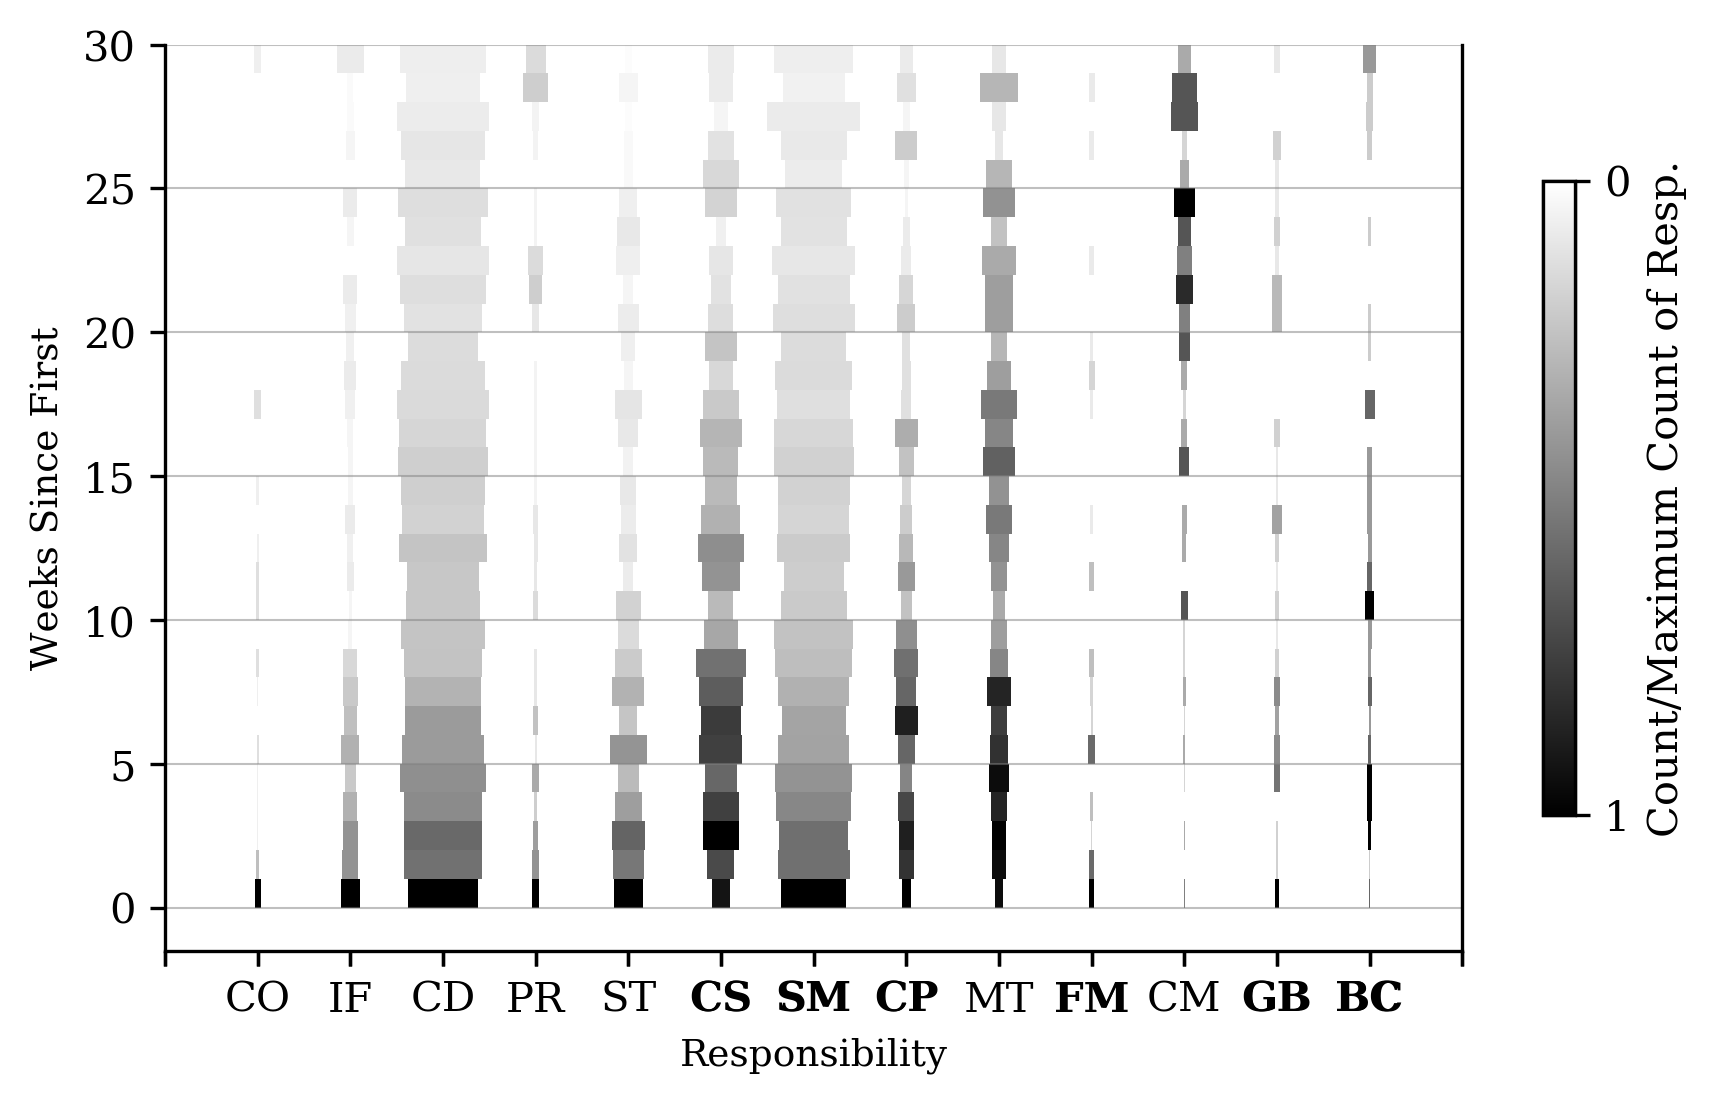

In [10]:
# Configure width of each vertical histogram
binned_maxima = np.max(table.values, axis=1)
counts_maxima = np.max(counts.values, axis=1)
shade_data = 1-(counts.values.T/counts_maxima).T
x_locs = np.arange(0, (len(binned_maxima)+2) * np.max(binned_maxima) * gap, np.max(binned_maxima) * gap)

# Draw the vertical histograms, with two deads on each side
figure, axes = mpl.subplots()
axes.barh(centers, 0, height = heights, left = x_locs[0])
for x, binned_data, shaded_data in zip(x_locs[1:], table.values, shade_data):
    axes.barh(centers, binned_data, height = heights, 
              left = x - 0.5 * binned_data,
              color = [(c,c,c) for c in shaded_data])
axes.barh(centers, 0, height = heights, left = x_locs[len(x_locs)-1])

# Set labels, write them, and rotate them aptly
labels = [" "] + code_names
axes.set_xticks(x_locs)
axes.set_xticklabels(labels, rotation = rot)

# Apply emphases labels to the same axis as our original
bolds = figure.add_axes(axes.get_position(), frameon=False)
emphases = [" "] + emphasis_names
bolds.set_xticks(x_locs)
bolds.set_xticklabels(emphases, weight = "bold", rotation = rot)
bolds.set_yticks([])

# Draw titles, do some beautification
# axes.set_title("Responsibility Count/Weekly Total vs. This Journal's Weeks Since First", fontsize = 18)
axes.set_ylabel("Weeks Since First", fontsize = 9)
axes.set_xlabel("Responsibility", fontsize = 9)
axes.set_ylim(top=num_weeks)
axes.spines["top"].set_visible(False)    
axes.spines["right"].set_visible(True)
axes.grid(color='grey', linestyle='-', axis='y', linewidth=0.5, alpha=0.5)

figure.savefig(fname="draft_no_cb.pdf", dpi=300, bbox_inches='tight', pad_inches = 0)

#Show the colorbar, but take into account the dead colobar needed for emphases labels
smap = ScalarMappable(cmap=mpl.cm.gray, norm=mpl.Normalize(0,1)); smap.set_array([])
dead_cb = figure.colorbar(smap, label="", ax=bolds, shrink = .7); dead_cb.set_ticks([])
cb = figure.colorbar(smap, label="Count/Maximum Count of Resp.", ax=axes, shrink = .7)
cb.set_ticks([0,1]); cb.set_ticklabels(["1", "0"])

figure.savefig(fname="draft_cb.pdf", dpi=300, bbox_inches='tight', pad_inches = 0)

##### Vertical Histograms, by Phase

This is simply the above visualization, but split into subplots such that each histogram is displayed within a plot among its peer responsibilities according to Jacobs Et Al. in "A Cancer Journey Framework: Guiding the Design of Holistic Health Technology".

In [15]:
%%capture
# Set up the sublots
fig, axes = mpl.subplots(nrows=2, ncols=2)
subdata =       [[0 for x in range(2)] for y in range(2)] 
countdata =     [[0 for x in range(2)] for y in range(2)] 
labels =        [[0 for x in range(2)] for y in range(2)] 
binned_maxima = [[0 for x in range(2)] for y in range(2)] 
counts_maxima = [[0 for x in range(2)] for y in range(2)] 
shade_data =    [[0 for x in range(2)] for y in range(2)] 
x_locs =        [[0 for x in range(2)] for y in range(2)] 

# Designate what data goes where
subdata[0][0] = np.array([table.T["communicating"].values])
subdata[1][0] = table["info_filtering":"preparation"].values
subdata[0][1] = table["symptom_management":"financial_management"].values
subdata[1][1] = table["continued_monitoring":"behavior_changes"].values

# Designate what data goes where
countdata[0][0] = np.array([counts.T["communicating"].values])
countdata[1][0] = counts["info_filtering":"preparation"].values
countdata[0][1] = counts["symptom_management":"financial_management"].values
countdata[1][1] = counts["continued_monitoring":"behavior_changes"].values

# Label the plots, accounting for dead zero-place
labels[0][0] = [" "] + friendly_names[0:1]
labels[1][0] = [" "] + friendly_names[1:5]
labels[0][1] = [" "] + friendly_names[5:10]
labels[1][1] = [" "] + friendly_names[10:]

# Set titles per CJFW Phase Labels
axes[0,0].set_title("Screening and Diagnosis", fontsize = 10)
axes[1,0].set_title("Information Seeking", fontsize = 10)
axes[0,1].set_title("Acute Care and Treatment", fontsize = 10)
axes[1,1].set_title("No Evidence of Disease", fontsize = 10)

for i in range(0,2):
    for j in range(0,2):
        binned_maxima[i][j] = np.max(subdata[i][j], axis=1)
        counts_maxima[i][j] = np.max(countdata[i][j], axis=1)
        shade_data[i][j] = 1-(countdata[i][j].T/counts_maxima[i][j]).T
        x_locs[i][j] = np.arange(0, (len(binned_maxima[i][j]) + 2) * np.max(binned_maxima[i][j]) * gap,
                                    (np.max(binned_maxima[i][j]) * gap) + .00001)
        axes[i,j].set_xticks(x_locs[i][j])
        axes[i,j].set_xticklabels(labels[i][j], horizontalalignment="right", rotation=rot)

# Set axis titles and do some beautification
for i in range(0,2): 
    for j in range(0,2):
        axes[i,j].barh(centers, 0, height = heights, left = x_locs[i][j][0])
        for x, binned_data, shaded_data in zip(x_locs[i][j][1:], subdata[i][j], shade_data[i][j]):

            axes[i,j].barh(centers, binned_data, height = heights, left =  x - (.5 * binned_data),
                           color = [(c,c,c) for c in shaded_data])
        axes[i,j].barh(centers, 0, height = heights, left = x_locs[i][j][len(x_locs[i][j])-1])
        axes[i,j].set_xlabel("Responsibility", fontsize = 9)
        axes[i,j].set_ylabel("Weeks Since First", fontsize = 9)
        axes[i,j].spines["top"].set_visible(False)    
        axes[i,j].spines["right"].set_visible(False)   
        axes[i,j].grid(color='grey', linestyle='-', axis='y', linewidth=0.5, alpha=0.5)

#smap = ScalarMappable(cmap=mpl.cm.gray, norm=mpl.Normalize(0,1)); smap.set_array([])
#cax,kw = lib.colorbar.make_axes([ax for ax in axes.flat])
#divider = make_axes_locatable(mpl.gca())
#cax = divider.append_axes("right", "5%", pad="3%")
#cb = mpl.colorbar(smap, cax=cax, **kw)

#divider = make_axes_locatable(mpl.gca())
#cax = divider.append_axes("right", "5%", pad="3%")
#cb = mpl.colorbar(smap, cax=cax)
#cb.set_ticks([0,1]); cb.set_ticklabels(["1", "0"])

#mpl.tight_layout(); mpl.show()

##### Dual Comparison

Based on the compare variable, we are comparing two responsibility histograms side-by-side in the same plot.

In [12]:
compare = ["Symptom Management", "Continued Monitoring"]

In [14]:
%%capture
# Set up the subplots
fig, axes = mpl.subplots()

# What two responsibilities do we compare?
data = table.T[[responsibility_names[friendly_names.index(compare[0])], 
                responsibility_names[friendly_names.index(compare[1])]]].T.values
counta = counts.T[[responsibility_names[friendly_names.index(compare[0])], 
                responsibility_names[friendly_names.index(compare[1])]]].T.values
 
# Configure width of each vertical histogram
binned_maxima = np.max(data, axis=1)
counts_maxima = np.max(counta, axis=1)
shade_data = 1-(counta.T/counts_maxima).T
x_loc = np.arange(0, (len(binned_maxima) + 2) * np.max(binned_maxima) * gap, np.max(binned_maxima) * gap)

# Set ticks, labels, titles
axes.set_xticks(x_loc)
axes.set_xticklabels(" ")
axes.set_title(compare[0] + " v. " + compare[1], fontsize = 18)

#Draw the Graphs with Dead Hists on either side for padding
axes.barh(centers, 0, height = heights, left = x_loc[0])
axes.barh(centers, data[0], height = heights, left =  (x_loc[1] - data[0]),
               color = [(1,c,c) for c in shade_data[0]])
axes.barh(centers, data[1], height = heights, left =  (x_loc[1]),
               color = [(c,c,1) for c in shade_data[1]])
axes.barh(centers, 0, height = heights, left = x_loc[2])

# Beautification Tasks
axes.set_xlabel(compare[0] + " : " + compare[1], fontsize = 14)
axes.set_ylabel("Weeks Since First", fontsize = 14)
axes.spines["top"].set_visible(False)    
axes.spines["right"].set_visible(False)   
axes.grid(color='grey', linestyle='-', axis='y', linewidth=0.5, alpha=0.5)

smap = ScalarMappable(cmap=colormap.gray, norm=mpl.Normalize(0,1)); smap.set_array([])
cb = figure.colorbar(smap, label="Count/Maximum Count of Resp.", ax=axes, shrink = .8)
cb.set_ticks([0,1]); cb.set_ticklabels(["1", "0"])
        
#mpl.tight_layout(); mpl.show()